In [1]:
%matplotlib inline  

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pickle
import os
import warnings 
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import kernels, mean_functions
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Samplers.likelihoods import LikGaussian
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import MeasureSetGenerator
from Utilities.normalization import normalize_data
from Utilities.exp_utils import get_input_range
from Metrics.sampling import compute_rhat_regression
from Metrics import uncertainty as uncertainty_metrics
from Networks.mlp_masked import MLPMasked
from Networks.regression_net_masked import RegressionNetMasked
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Utilities import util
from Utilities.priors import LogNormal

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
SEED = 123
util.set_seed(SEED)

In [7]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [8]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci"
noise_var = 0.1

In [9]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# 1. Setup

In [10]:
out_dir = "./exp/uci/optim_gaussian"
util.ensure_dir(out_dir)

## 1.1 Optimize the Prior

In [11]:
# Configurations for the prior optimization
D = 3
mapper_batch_size = 256
prior_opt_configurations = {
    "n_data": mapper_batch_size,                            # The batch size 
    "num_iters": 6000,                                      # The number of iterations of the prior optimization
    "lambd": (torch.tensor([1])/D).to(device),              # The regularization parameters for the layers
    "n_samples": 128,                                       # The number of function samples
    "lr": 1e-1,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every":500,                                  # After how many epochs a checkpoint should be saved
    "shift": 1,                                             # The shift of the schedule for the regularization of the loss
    "scale": 12                                             # The scale of the schedule for the regularization of the loss
}

In [12]:
masks_list = []
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    # BEFORE RBF
    kernel = kernels.Exponential(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
    kernel = kernel.to(device)
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, D = D, activation_fn=activation_fn, scaled_variance=True, device=device)
    mlp_reparam = mlp_reparam.to(device)
    # Perform optimization
    mapper = PriorOptimisationMapper(out_dir=saved_dir, device=device, kernel = kernel).to(device)
    p_hist, loss_hist = mapper.optimize(mlp_reparam, rand_generator, output_dim=output_dim, **prior_opt_configurations)
    path = os.path.join(saved_dir, "loss_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, loss_hist, fmt='%.6e')
    path = os.path.join(saved_dir, "pruned_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, p_hist, fmt='%.6e')
    print("----" * 20)
    masks_list.append(mlp_reparam.get_det_masks())
# Save the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "wb") as f:
    pickle.dump(masks_list, f)

Loading split 1 of boston dataset
>>> Iteration #   1: Difference from GP 20721.2775 Number of pruned stochastic weights: 0
>>> Iteration # 100: Difference from GP 22330.0766 Number of pruned stochastic weights: 0
>>> Iteration # 200: Difference from GP 20639.9855 Number of pruned stochastic weights: 0
>>> Iteration # 300: Difference from GP 20407.9682 Number of pruned stochastic weights: 0
>>> Iteration # 400: Difference from GP 19915.3447 Number of pruned stochastic weights: 0
>>> Iteration # 500: Difference from GP 20473.6837 Number of pruned stochastic weights: 0
>>> Iteration # 600: Difference from GP 19992.5713 Number of pruned stochastic weights: 0
>>> Iteration # 700: Difference from GP 20148.1185 Number of pruned stochastic weights: 0
>>> Iteration # 800: Difference from GP 20593.4099 Number of pruned stochastic weights: 0
>>> Iteration # 900: Difference from GP 20135.3299 Number of pruned stochastic weights: 5
>>> Iteration # 1000: Difference from GP 20280.1295 Number of prun

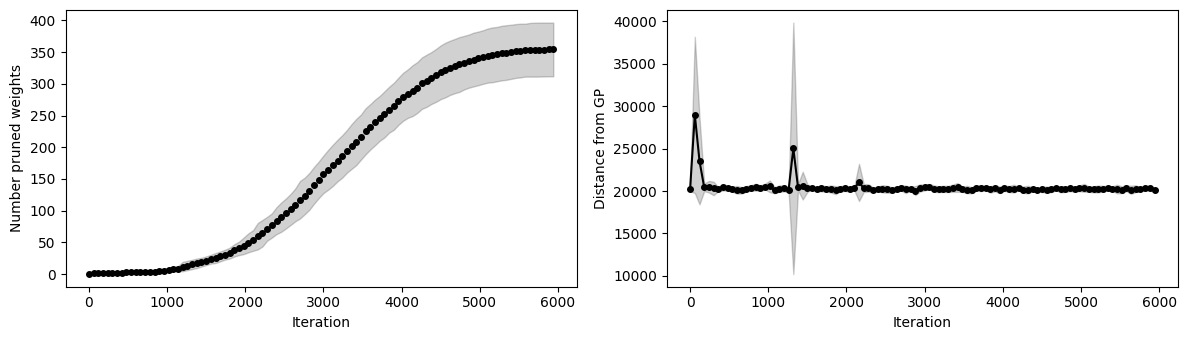

In [13]:
# Visualize the convergence
lossdist_data = []
pruned_vals_data = []
for i in range(0, n_splits):
    lossdist_file = os.path.join(out_dir, str(i), "loss_values.log")
    pruned_vals_file = os.path.join(out_dir, str(i), "pruned_values.log")
    lossdist_data.append(np.loadtxt(lossdist_file))
    pruned_vals_data.append(np.loadtxt(pruned_vals_file))

lossdist_vals = np.stack(lossdist_data)
pruned_vals = np.stack(pruned_vals_data)
indices = np.arange(prior_opt_configurations["num_iters"])[::60]
mean_loss = lossdist_vals.mean(0)
std_loss = lossdist_vals.std(0)
mean_pruned = pruned_vals.mean(0)
std_pruned = pruned_vals.std(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, mean_pruned[indices], "ko", ms=4)
axes[0].fill_between(indices, mean_pruned[indices] - std_pruned[indices],
                 mean_pruned[indices] + std_pruned[indices], alpha=0.18, color="k")
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, mean_loss[indices], "-ko", ms=4)
axes[1].fill_between(indices, mean_loss[indices]-std_loss[indices],
                     mean_loss[indices]+std_loss[indices], alpha = 0.18, color = "k")
axes[1].set_ylabel("Distance from GP")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## 1.2 Posterior Inference

In [12]:
# Configure the SGHMC sampler
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000, #2000        # Number of burn-in steps
    "keep_every": 2000,    #2000         # Thinning interval
    "lr": 3e-2,    #1e-1                   # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2, #5e-2                  # Momentum coefficient
    "print_every_n_samples": 5
}
# Load the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "rb") as f:
    masks_list = pickle.load(f)

In [ ]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, 
                    bias_mask, D = D, device = device)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "it-{}.ckpt".format(prior_opt_configurations["num_iters"]))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.1688e+00 RMSE = 1.4270e+00 Pruned weights: 106
Samples #    10 : NLL =  2.1850e+00 RMSE = 1.4096e+00 Pruned weights: 117
Samples #    15 : NLL =  2.1927e+00 RMSE = 1.4198e+00 Pruned weights: 124
Samples #    20 : NLL =  2.2026e+00 RMSE = 1.4438e+00 Pruned weights: 129
Samples #    25 : NLL =  2.2145e+00 RMSE = 1.4893e+00 Pruned weights: 138
Samples #    30 : NLL =  2.2246e+00 RMSE = 1.5190e+00 Pruned weights: 140
Chain: 2
Samples #    35 : NLL =  2.2416e+00 RMSE = 1.5630e+00 Pruned weights: 163
Samples #    40 : NLL =  2.2534e+00 RMSE = 1.6104e+00 Pruned weights: 164
Samples #    45 : NLL =  2.2640e+00 RMSE = 1.6531e+00 Pruned weights: 167
Samples #    50 : NLL =  2.2717e+00 RMSE = 1.6982e+00 Pruned weights: 168
Samples #    55 : NLL =  2.2783e+00 RMSE = 1.7323e+00 Pruned weights: 170
Samples #    60 : NLL =  2.2839e+00 RMSE = 1.7722e+00 Pruned weights: 170
Chain: 3
Samples #    65 : NLL =  2.2913e+00 RMSE = 1.8203e+

In [ ]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir, "optim_results.csv"), sep="\t", index=False)

### Final Result

In [ ]:
result_df = pd.read_csv(os.path.join(out_dir, "optim_results.csv"), sep = "\t")
print("Final result:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df['rmse'].mean()), float(result_df['rmse'].std()),
        float(result_df['nll'].mean()), float(result_df['nll'].std())))
print("\nFinal results benchmark:")
print("> RMSE: mean 2.7970e+00; std 9.1485e-01 | NLL: mean 2.4699e+00 std 1.4601e-01")